# Trading Strategies powered by Machine Learning - Support_Vector_Classifier

## Support_Vector_Classifier with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
from backtesting import Strategy
from sklearn import svm
from sklearn import preprocessing

## Getting the Data

In [4]:
XAUUSD = load_data()

In [5]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [6]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


## ML

### Class and Strategy ML

In [7]:
class Support_Vector_Classifier(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [8]:
strategy = Support_Vector_Classifier
account_size = 10000
folder_ML_Strategy = 'Support Vector Classifier'

In [9]:
from backtesting import Backtest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
from util.ATR import *
from util.SMA import *
from util.RSI import *
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_SVC():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def get_rsi(self, df, rsi_period):
        chg = df['Close'].diff(1)
        gain = chg.mask(chg < 0, 0)
        loss = chg.mask(chg > 0, 0)
        avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        rs = abs(avg_gain/avg_loss)
        rsi = 100 - (100/(1+rs))
        return rsi

    def Create_Features(self):

        df = self.data.copy()

        # relative strength index
        df['rsi14'] = self.get_rsi(df, 14)
        df['ATR'] = ATR(df, 20)['ATR']

        periods = 14
        moving_av = 3

        df["roll_low"] = df['Low'].rolling(periods).min()
        df["roll_high"] = df['High'].rolling(periods).max()
        df["K"] = (df.Close - df.roll_low) / (df.roll_high - df.roll_low) * 100
        df["D"] = df.K.rolling(moving_av).mean()

        df = df.drop('roll_low', axis=1)
        df = df.drop('roll_high', axis=1)

        self.data = df

    def Add_Signal(self):

        df = self.data.copy()
        df["returns"] = np.log(df['Close'].div(df['Close'].shift(1)))
        df['signal_t1'] = np.sign(df.returns)
        df['Signal'] = df.signal_t1.shift(-1)
        df = df.drop(columns=['returns', 'signal_t1'])
        # df = df.dropna()

        df.fillna(0, inplace=True)

        self.data = df

    def Train_Model(self):
        self.Create_Features()
        self.Add_Signal()

        # Extract data within the specified date range
        self.data_train = self.data.loc[self.start_train:self.end_train].copy()
        self.data_test = self.data.loc[self.start_test:self.end_test].copy()

        # Drop missing values from the training dataset
        self.data_train.dropna(inplace=True)

        # Ensure 'Signal' column exists in data_train
        if 'Signal' not in self.data_train.columns:
            raise ValueError("'Signal' column is missing in data_train")

        # Define features and target columns
        features = ['rsi14', 'ATR', 'K', 'D']
        target = 'Signal'

        # Prepare data for model training
        X_train = self.data_train[features]
        y_train = self.data_train[target]

        # Normalize/Scale data using MaxAbsScaler
        max_abs_scaler = preprocessing.MaxAbsScaler()
        X_train_scaled = max_abs_scaler.fit_transform(X_train)

        self.model = svm.SVC(kernel='rbf', decision_function_shape='ovo')

        try:
            # Fit the model
            self.model.fit(X_train_scaled, y_train)

            # Make predictions on training and test data
            self.data_train['pred'] = self.model.predict(X_train_scaled)
            self.data_test['pred'] = self.model.predict(
                max_abs_scaler.transform(self.data_test[features]))
        except Exception as e:
            print(f"Error occurred during model fitting: {e}")

    def Backtest(self, data, account_size=10000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100, commission=0.0002)
        result = backtest.run()
        return result

    def Run(self):

        self.Train_Model()

        result_train = self.Backtest(self.data_train)

        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [10]:
ML_Class = ML_SVC

## TF D1

In [11]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [12]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [13]:
train, test = ml.Run()

### In-Sample Backtesting

In [14]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                   4747 days 00:00:00
Exposure Time [%]                   99.950642
Equity Final [$]                 11574.214633
Equity Peak [$]                  11812.067706
Return [%]                          15.742146
Buy & Hold Return [%]              138.530025
Return (Ann.) [%]                    0.913352
Volatility (Ann.) [%]                1.738629
Sharpe Ratio                         0.525329
Sortino Ratio                        0.753235
Calmar Ratio                         0.154151
Max. Drawdown [%]                    -5.92506
Avg. Drawdown [%]                   -0.334824
Max. Drawdown Duration     2970 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                   27
Win Rate [%]                        77.777778
Best Trade [%]                     106.751296
Worst Trade [%]                    -15.750953
Avg. Trade [%]                    

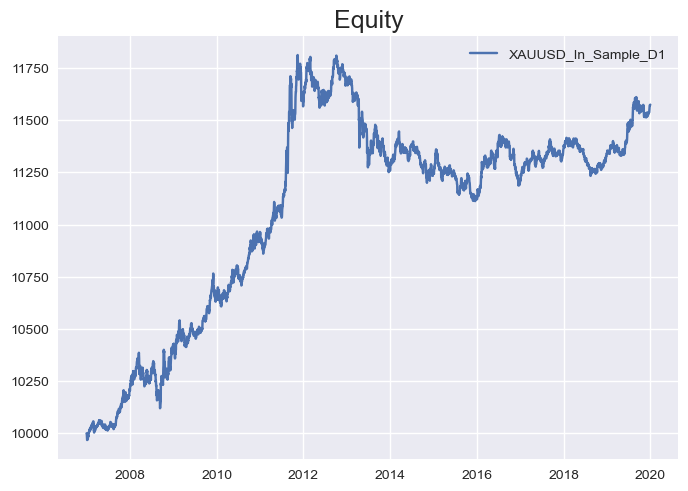

In [15]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [16]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   1164 days 00:00:00
Exposure Time [%]                   99.798184
Equity Final [$]                 10595.706295
Equity Peak [$]                  10750.900295
Return [%]                           5.957063
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    1.482288
Volatility (Ann.) [%]                2.575539
Sharpe Ratio                         0.575525
Sortino Ratio                        0.834804
Calmar Ratio                         0.442918
Max. Drawdown [%]                   -3.346641
Avg. Drawdown [%]                   -0.721844
Max. Drawdown Duration      567 days 00:00:00
Avg. Drawdown Duration       64 days 00:00:00
# Trades                                    9
Win Rate [%]                        66.666667
Best Trade [%]                      21.038631
Worst Trade [%]                     -7.743083
Avg. Trade [%]                    

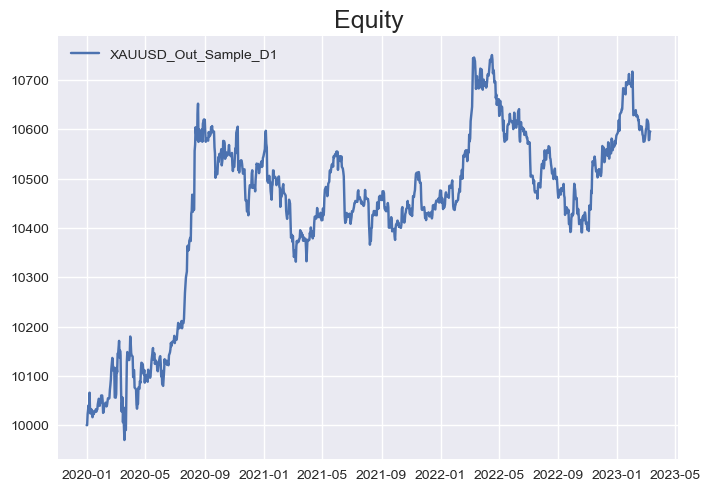

In [17]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [18]:
filename_train = f'result_{TF}_In_Sample.csv'

In [19]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [20]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [21]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [22]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [23]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [24]:
train, test = ml.Run()

### In-Sample Backtesting

In [25]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 20:00:00
Exposure Time [%]                   99.990417
Equity Final [$]                  9465.556615
Equity Peak [$]                   10342.06751
Return [%]                          -5.344434
Buy & Hold Return [%]              138.697429
Return (Ann.) [%]                   -0.341029
Volatility (Ann.) [%]                1.895188
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -8.661507
Avg. Drawdown [%]                   -0.424226
Max. Drawdown Duration     3035 days 08:00:00
Avg. Drawdown Duration       81 days 13:00:00
# Trades                                 3163
Win Rate [%]                        69.238065
Best Trade [%]                       7.488728
Worst Trade [%]                    -18.299672
Avg. Trade [%]                    

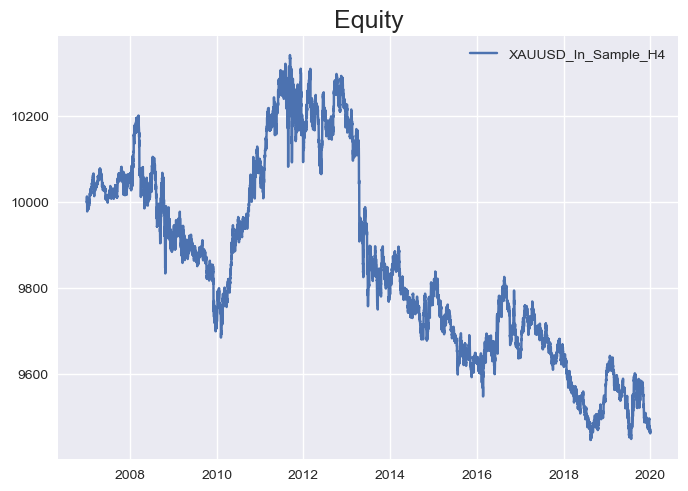

In [26]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [27]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 20:00:00
Exposure Time [%]                   99.960823
Equity Final [$]                  9509.171968
Equity Peak [$]                  10010.450078
Return [%]                           -4.90828
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -1.271637
Volatility (Ann.) [%]                2.585105
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -8.048653
Avg. Drawdown [%]                   -1.520647
Max. Drawdown Duration      963 days 12:00:00
Avg. Drawdown Duration      166 days 06:00:00
# Trades                                  858
Win Rate [%]                        67.365967
Best Trade [%]                       2.962603
Worst Trade [%]                     -8.878987
Avg. Trade [%]                    

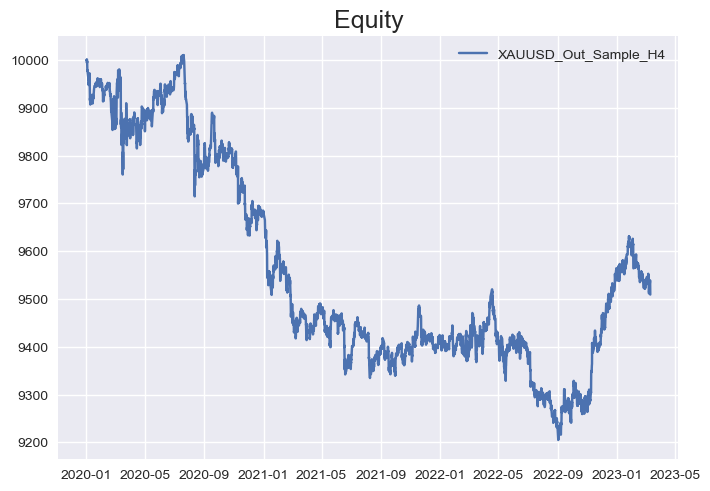

In [28]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [29]:
filename_train = f'result_{TF}_In_Sample.csv'

In [30]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [31]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [32]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [33]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [34]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [35]:
train, test = ml.Run()

### In-Sample Backtesting

In [36]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 21:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                  5921.527962
Equity Peak [$]                  10015.553855
Return [%]                          -40.78472
Buy & Hold Return [%]              138.649736
Return (Ann.) [%]                   -3.206691
Volatility (Ann.) [%]                2.045933
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -40.895696
Avg. Drawdown [%]                   -2.826068
Max. Drawdown Duration     4457 days 11:00:00
Avg. Drawdown Duration      316 days 13:00:00
# Trades                                20485
Win Rate [%]                        61.781792
Best Trade [%]                       3.154445
Worst Trade [%]                    -11.039415
Avg. Trade [%]                    

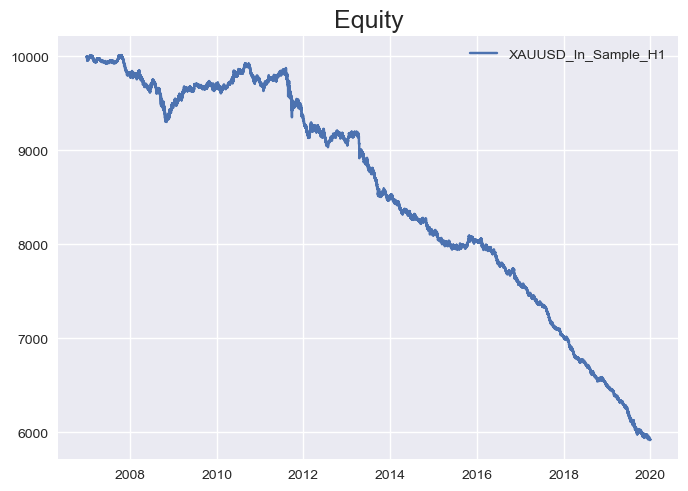

In [37]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [38]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                  9301.055982
Equity Peak [$]                  10196.420512
Return [%]                           -6.98944
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -1.825632
Volatility (Ann.) [%]                2.531773
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -9.363522
Avg. Drawdown [%]                   -0.331641
Max. Drawdown Duration      977 days 15:00:00
Avg. Drawdown Duration       25 days 05:00:00
# Trades                                 4821
Win Rate [%]                        63.264883
Best Trade [%]                        1.65221
Worst Trade [%]                       -4.7185
Avg. Trade [%]                    

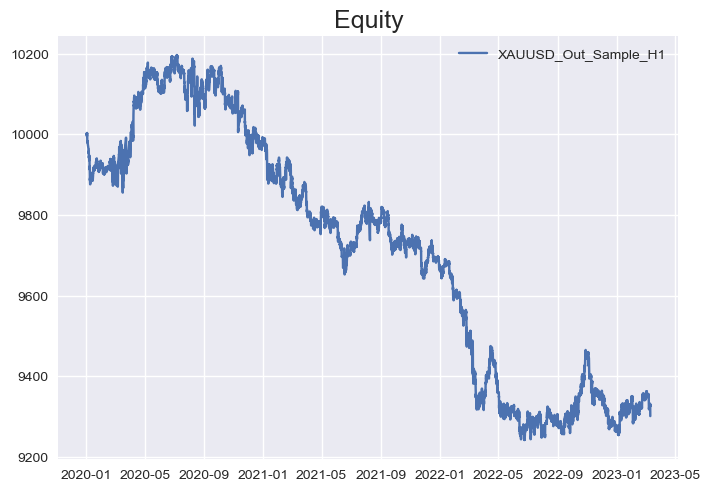

In [39]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [40]:
filename_train = f'result_{TF}_In_Sample.csv'

In [41]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [42]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [43]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [44]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [45]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [46]:
train, test = ml.Run()

### In-Sample Backtesting

In [47]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 21:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                  1582.751043
Equity Peak [$]                  10000.231647
Return [%]                          -84.17249
Buy & Hold Return [%]              138.705317
Return (Ann.) [%]                  -10.831354
Volatility (Ann.) [%]                3.043678
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -84.302477
Avg. Drawdown [%]                  -28.104286
Max. Drawdown Duration     4747 days 12:30:00
Avg. Drawdown Duration     1582 days 15:00:00
# Trades                                43207
Win Rate [%]                        58.821487
Best Trade [%]                       3.428308
Worst Trade [%]                     -12.55039
Avg. Trade [%]                    

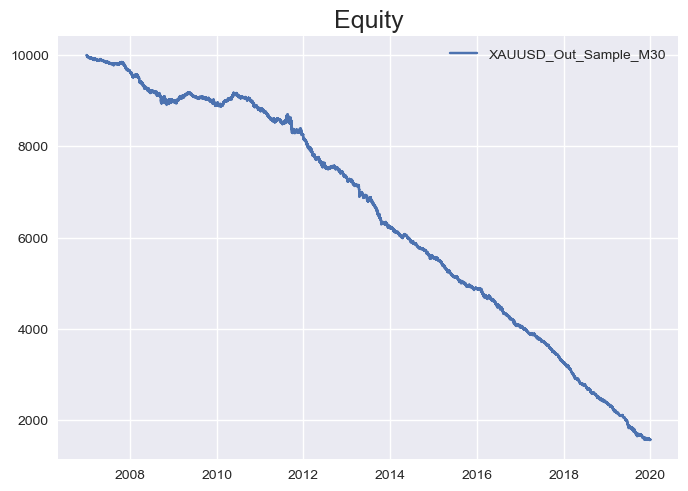

In [48]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [49]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                  7678.886051
Equity Peak [$]                  10109.098218
Return [%]                         -23.211139
Buy & Hold Return [%]               22.670469
Return (Ann.) [%]                   -6.495471
Volatility (Ann.) [%]                2.573283
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -24.653233
Avg. Drawdown [%]                   -1.790855
Max. Drawdown Duration     1095 days 00:00:00
Avg. Drawdown Duration       77 days 13:30:00
# Trades                                 9984
Win Rate [%]                        60.627003
Best Trade [%]                       1.898097
Worst Trade [%]                     -5.346452
Avg. Trade [%]                    

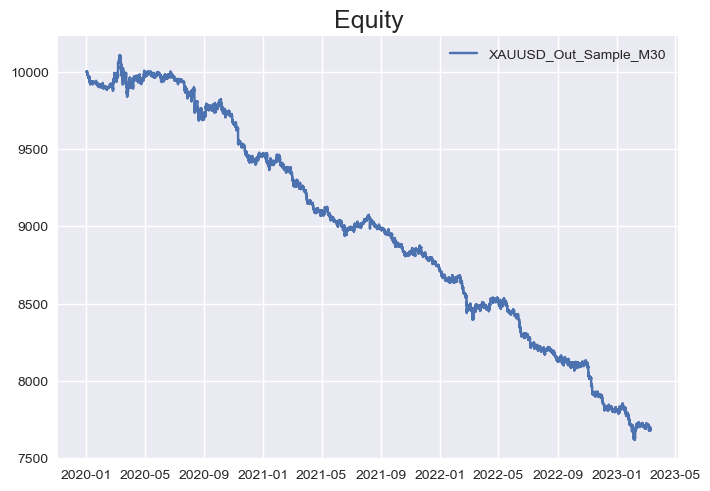

In [50]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [51]:
filename_train = f'result_{TF}_In_Sample.csv'

In [52]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [ ]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')